In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
from six.moves import cPickle as pickle
%matplotlib inline

/home/josh/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Read the training data

In [2]:
#pickle_file = 'train.pickle'
'''
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X_1 = save['data']
    train_outcome_1 = save['outcome']
    del save  # hint to help gc free up memory
'''
    
pickle_file = 'train2.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X_0 = save['data']
    train_outcome_0 = save['outcome']
    del save  # hint to help gc free up memory
    
'''
pickle_file = 'test.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    test_X_1 = save['data']
    test_outcome_1 = save['outcome']
    del save  # hint to help gc free up memory
    
'''

pickle_file = 'test2.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    test_X_0 = save['data']
    test_outcome_0 = save['outcome']
    del save  # hint to help gc free up memory

In [3]:
#reformat the label
#for each digit, add a 'end_digit' as '10'
#for each label, add a digit size
#each of them is a one-hot coding

def label_reformat(label, max_size = 5):
    digit_size = np.asarray([len(x) for x in label])
    digit_size[digit_size > max_size]= max_size
    digit_size = ((np.arange(max_size)+1) == digit_size[:,None]).astype(np.float32)
    
    digits = {}
    end_digit = 10.0
    for i in range(max_size):
        digit_coding = np.asarray( [x[i] if len(x)>i else end_digit for x in label])
        digit_coding = (np.arange(end_digit+1) == digit_coding[:,None]).astype(np.float32)
        digits['digit_'+ str(i)] = digit_coding
        
    return digit_size, digits   

# sample a smaller data

In [4]:
#train_X_0 = np.vstack((train_X_1 ,train_X_2 ))

In [5]:
train_X_0.shape

(33402, 64, 64, 3)

In [6]:
train_label = train_outcome_0['label']

for i in range(8):
    pickle_file = 'extra_crop_' + str(i) + '.pickle'
    
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        extra_X_tmp = save['data']
        extra_outcome_tmp = save['outcome']
        del save  # hint to help gc free up memory
        
        train_X_0 = np.vstack((train_X_0 ,extra_X_tmp ))
        train_label = train_label + extra_outcome_tmp['label']
        print '{}th extra incorperated into training data'.format(i)
        
    
    
    
    
    

0th extra incorperated into training data
1th extra incorperated into training data
2th extra incorperated into training data
3th extra incorperated into training data
4th extra incorperated into training data
5th extra incorperated into training data
6th extra incorperated into training data
7th extra incorperated into training data


In [7]:
#train_X_0 = np.vstack((train_X_1 ,train_X_2 ))

image_size = train_X_0.shape[1]
num_channels = train_X_0.shape[3]
batch_size = 200
val_size = 50
test_size = 50
reg = 0.001


#train_label = train_outcome_1['label'] +  train_outcome_2['label']
#train_label = train_outcome_0['label']
train_digit_size, train_digits = label_reformat(train_label)
train_X = train_X_0


val_label = test_outcome_0['label']
val_digit_size, val_digits = label_reformat(val_label)
val_X = test_X_0

val_size = val_X.shape[0]

In [8]:
print train_digit_size.shape
print train_digits['digit_0'].shape
print train_X.shape

(235755, 5)
(235755, 11)
(235755, 64, 64, 3)


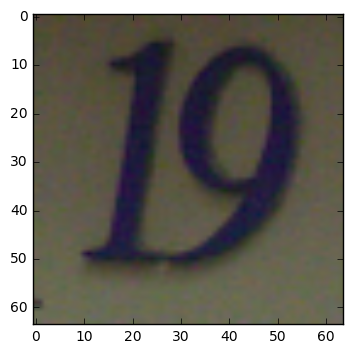

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


In [9]:
plt.imshow(train_X[0,:,:,:])
plt.show()
print train_digits['digit_0'][0]
print train_digits['digit_1'][0]

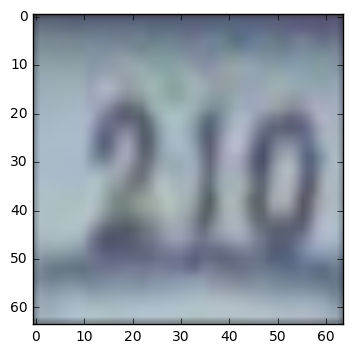

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [10]:
plt.imshow(val_X[1,:,:,:])
plt.show()
print val_digits['digit_0'][1]
print val_digits['digit_1'][1]

# start tensorflow session

In [11]:
def next_batch(X, y_dsize, y_ds, batch_size=50, replace = True):
    idx = np.random.choice(X.shape[0],batch_size, replace = replace)
    batch_x = X[idx,:,:,:]
    batch_y_dsize = y_dsize[idx,:]
    batch_y_d1 = y_ds['digit_0'][idx,:]
    batch_y_d2 = y_ds['digit_1'][idx,:]
    batch_y_d3 = y_ds['digit_2'][idx,:]
    batch_y_d4 = y_ds['digit_3'][idx,:]
    batch_y_d5 = y_ds['digit_4'][idx,:]
    
    return batch_x, batch_y_dsize, batch_y_d1, batch_y_d2, batch_y_d3, batch_y_d4, batch_y_d5


In [12]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def max_pool_2x2_same(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')

# Build Graph

In [13]:
# this is a simpler version of Tensorflow's 'official' version. See:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L102
# http://r2rt.com/implementing-batch-normalization-in-tensorflow.html
def batch_norm_wrapper(inputs, is_training, decay = 0.999, epsilon = 1e-3):

    scale = tf.Variable( tf.ones(inputs.get_shape()[-1]) )
    beta = tf.Variable(tf.zeros(inputs.get_shape()[-1]))
    pop_mean = tf.Variable(tf.zeros(inputs.get_shape()[-1]), trainable=False)
    pop_var = tf.Variable(tf.ones(inputs.get_shape()[-1]), trainable=False)

    if is_training:
        #for conv layer, use global normalization
        batch_mean, batch_var = tf.nn.moments(inputs,[0,1,2])
        #print pop_mean.get_shape()
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs, batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)
    
    

def batch_norm_wrapper_simple(inputs, is_training, decay = 0.999, epsilon = 1e-3):

    scale = tf.Variable( tf.ones(inputs.get_shape()[-1]) )
    beta = tf.Variable(tf.zeros(inputs.get_shape()[-1]))
    pop_mean = tf.Variable(tf.zeros(inputs.get_shape()[-1]), trainable=False)
    pop_var = tf.Variable(tf.ones(inputs.get_shape()[-1]), trainable=False)

    if is_training:
        #for conv layer, use global normalization
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        #print pop_mean.get_shape()
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs, batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)

In [14]:
def build_graph(is_training):
    
    # shape = [None, ...], the None element of the shape corresponds to a variable-sized dimension.
    x_image = tf.placeholder(tf.float32, shape=[None, image_size, image_size, num_channels])
    
    y_d1 = tf.placeholder(tf.float32, shape=[None, 11])
    y_d2 = tf.placeholder(tf.float32, shape=[None, 11])
    y_d3 = tf.placeholder(tf.float32, shape=[None, 11])
    y_d4 = tf.placeholder(tf.float32, shape=[None, 11])
    y_d5 = tf.placeholder(tf.float32, shape=[None, 11])
    
    y_dsize = tf.placeholder(tf.float32, shape=[None, 5])
    

    #first layer
    W_conv1 = weight_variable([5, 5, num_channels, 32])
    b_conv1 = bias_variable([32])
    
    z_conv1 = conv2d(x_image, W_conv1) + b_conv1
    z_conv1_BN = batch_norm_wrapper(z_conv1, is_training)
    h_conv1 = tf.nn.relu(z_conv1_BN)
    
    h_pool1 = max_pool_2x2(h_conv1)
    

    #second layer
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    
    z_conv2 = conv2d(h_pool1, W_conv2) + b_conv2
    z_conv2_BN = batch_norm_wrapper(z_conv2, is_training)
    h_conv2 = tf.nn.relu( z_conv2_BN )
    
    h_pool2 = max_pool_2x2_same(h_conv2)
    
    #third layer
    W_conv3 = weight_variable([5, 5, 64, 128])
    b_conv3 = bias_variable([128])

    z_conv3 = conv2d(h_pool2, W_conv3) + b_conv3
    z_conv3_BN = batch_norm_wrapper(z_conv3, is_training)
    h_conv3 = tf.nn.relu( z_conv3_BN )

    h_pool3 = max_pool_2x2(h_conv3)
    
    #fourth layer    
    W_conv4 = weight_variable([5, 5, 128, 160])
    b_conv4 = bias_variable([160])

    z_conv4 = conv2d(h_pool3, W_conv4) + b_conv4
    z_conv4_BN = batch_norm_wrapper(z_conv4, is_training)
    h_conv4 = tf.nn.relu( z_conv4_BN )
    
    h_pool4 = max_pool_2x2_same(h_conv4)
    
    
    W_conv5 = weight_variable([5, 5, 160, 180])
    b_conv5 = bias_variable([180])

    z_conv5 = conv2d(h_pool4, W_conv5) + b_conv5
    z_conv5_BN = batch_norm_wrapper(z_conv5, is_training)
    h_conv5 = tf.nn.relu( z_conv5_BN )
    h_pool5 = max_pool_2x2_same(h_conv5)
    
    
    W_conv6 = weight_variable([5, 5, 180, 180])
    b_conv6 = bias_variable([180])

    z_conv6 = conv2d(h_pool5, W_conv6) + b_conv5
    z_conv6_BN = batch_norm_wrapper(z_conv6, is_training)
    h_conv6 = tf.nn.relu( z_conv6_BN )
    h_pool6 = max_pool_2x2_same(h_conv6)
    
    

    W_fc1 = weight_variable([16 * 16 * 180, 1024])
    b_fc1 = bias_variable([1024])

    h_pool6_flat = tf.reshape(h_pool6, [-1, 16*16*180])
    z_fc1 = tf.matmul(h_pool6_flat, W_fc1) + b_fc1
    z_fc1_BN = batch_norm_wrapper_simple(z_fc1, is_training)
    h_fc1 = tf.nn.relu(z_fc1_BN)
    
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    #first digit
    W_fc2_d1 = weight_variable([1024, 11])
    b_fc2_d1 = bias_variable([11])
    
    y_conv_d1 = tf.matmul(h_fc1_drop, W_fc2_d1) + b_fc2_d1
    
    #second digit
    W_fc2_d2 = weight_variable([1024, 11])
    b_fc2_d2 = bias_variable([11])
    
    y_conv_d2 = tf.matmul(h_fc1_drop, W_fc2_d2) + b_fc2_d2
    
    #third digit
    W_fc2_d3 = weight_variable([1024, 11])
    b_fc2_d3 = bias_variable([11])
    
    y_conv_d3 = tf.matmul(h_fc1_drop, W_fc2_d3) + b_fc2_d3
    
    #fourth digit
    W_fc2_d4 = weight_variable([1024, 11])
    b_fc2_d4 = bias_variable([11])
    
    y_conv_d4 = tf.matmul(h_fc1_drop, W_fc2_d4) + b_fc2_d4
    
    #fifth digit
    W_fc2_d5 = weight_variable([1024, 11])
    b_fc2_d5 = bias_variable([11])
    
    y_conv_d5 = tf.matmul(h_fc1_drop, W_fc2_d5) + b_fc2_d5
    
    #digit size
    W_fc2_dsize = weight_variable([1024, 5])
    b_fc2_dsize = bias_variable([5])
    
    y_conv_dsize = tf.matmul(h_fc1_drop, W_fc2_dsize) + b_fc2_dsize
    
    
    cross_entropy = ( tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d1, y_d1)) 
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d2, y_d2))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d3, y_d3))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d4, y_d4))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d5, y_d5))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_dsize, y_dsize))
                     ) + reg *(tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2) 
                               + tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(W_conv4)
                               + tf.nn.l2_loss(W_conv5) + tf.nn.l2_loss(W_conv6)
                               + tf.nn.l2_loss(W_fc1)
                               + tf.nn.l2_loss(W_fc2_d1) + tf.nn.l2_loss(W_fc2_d2) 
                               + tf.nn.l2_loss(W_fc2_d3) + tf.nn.l2_loss(W_fc2_d4) 
                               + tf.nn.l2_loss(W_fc2_d5) + tf.nn.l2_loss(W_fc2_dsize) 
                     )
    
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    
    #let's just check the first digit
    #correct_prediction = tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1))
    correct_prediction = ( tf.cast( tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1)) , tf.float32) 
                          * tf.cast( tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1)) , tf.float32)
                          * tf.cast( tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1)) , tf.float32)
                          * tf.cast( tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1)) , tf.float32)
                          * tf.cast( tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1)) , tf.float32)
                          )
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        


    return ( (x_image, y_dsize, y_d1, y_d2, y_d3, y_d4, y_d5, keep_prob) , train_step, accuracy, z_fc1_BN, tf.train.Saver())

In [15]:
#Build training graph, train and save the trained model

#sess.close()
tf.reset_default_graph()

( (x_image, y_dsize, y_d1, y_d2, y_d3, y_d4, y_d5, keep_prob), 
 train_step, accuracy, z_fc1_BN, saver) = build_graph(is_training=True)

num_steps = 10000
summary_frequency = 40

BNs_train, BNs_test, acc_train, acc_test = [], [], [], []


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(num_steps):
        (batch_x, batch_y_dsize, 
         batch_y_d1, batch_y_d2, 
         batch_y_d3, batch_y_d4, batch_y_d5) = next_batch(train_X, 
                                                          train_digit_size,train_digits, batch_size)
    
        feed_dict={x_image: batch_x, y_dsize: batch_y_dsize,
                   y_d1: batch_y_d1, y_d2: batch_y_d2, y_d3: batch_y_d3,
                   y_d4: batch_y_d4, y_d5: batch_y_d5, keep_prob: 0.5}
    
        train_step.run(feed_dict=feed_dict)
    
        if i%summary_frequency == 0:
            #train_accuracy = accuracy.eval(feed_dict=feed_dict)
            res_train = sess.run([accuracy,z_fc1_BN],feed_dict=feed_dict)
            print("step %d, training accuracy %g"%(i, res_train[0]))
            
            acc_train.append(res_train[0])
            BNs_train.append(np.mean(res_train[1],axis=0).flatten()[:10])
            
            (batch_x, batch_y_dsize, batch_y_d1,
             batch_y_d2, batch_y_d3, batch_y_d4, batch_y_d5) = next_batch(val_X, 
                                                                          val_digit_size, 
                                                                          val_digits, 
                                                                          batch_size, replace = False)
            feed_dict={x_image: batch_x, 
                       y_dsize: batch_y_dsize,y_d1: batch_y_d1, 
                       y_d2: batch_y_d2, y_d3: batch_y_d3,y_d4: batch_y_d4, 
                       y_d5: batch_y_d5, keep_prob: 1}
        
            res = sess.run([accuracy,z_fc1_BN],feed_dict=feed_dict)

            acc_test.append(res[0])

            # record the first 10 mean value of BN2 over the entire test set
            BNs_test.append(np.mean(res[1],axis=0).flatten()[:10])
        
    saved_model = saver.save(sess, 'temp-bn-save')

    
BNs_train, BNs_test, acc_train, acc_test = ( np.array(BNs_train), 
                                            np.array(BNs_test), 
                                            np.array(acc_train), 
                                            np.array(acc_test) )

step 0, training accuracy 0.09
step 40, training accuracy 0.13
step 80, training accuracy 0.23
step 120, training accuracy 0.32
step 160, training accuracy 0.32
step 200, training accuracy 0.405
step 240, training accuracy 0.4
step 280, training accuracy 0.45
step 320, training accuracy 0.53
step 360, training accuracy 0.575
step 400, training accuracy 0.515
step 440, training accuracy 0.55
step 480, training accuracy 0.655
step 520, training accuracy 0.64
step 560, training accuracy 0.72
step 600, training accuracy 0.68
step 640, training accuracy 0.775
step 680, training accuracy 0.745
step 720, training accuracy 0.735
step 760, training accuracy 0.775
step 800, training accuracy 0.73
step 840, training accuracy 0.75
step 880, training accuracy 0.77
step 920, training accuracy 0.795
step 960, training accuracy 0.75
step 1000, training accuracy 0.83
step 1040, training accuracy 0.79
step 1080, training accuracy 0.845
step 1120, training accuracy 0.81
step 1160, training accuracy 0.825

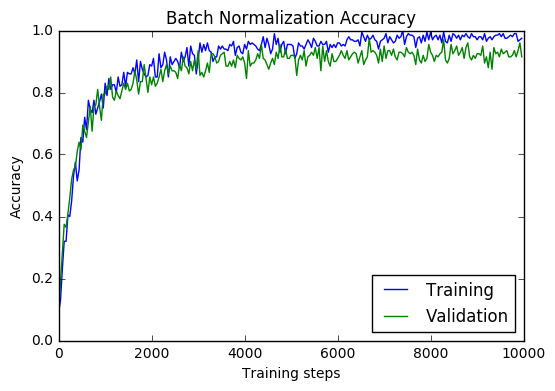

In [16]:
fig, ax = plt.subplots()

ax.plot(range(0,len(acc_train)*summary_frequency,summary_frequency),acc_train, label='Training')
ax.plot(range(0,len(acc_test)*summary_frequency,summary_frequency),acc_test, label='Validation')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

In [22]:
np.mean(acc_test[200:]), acc_test[249]

(0.92429996, 0.91500008)

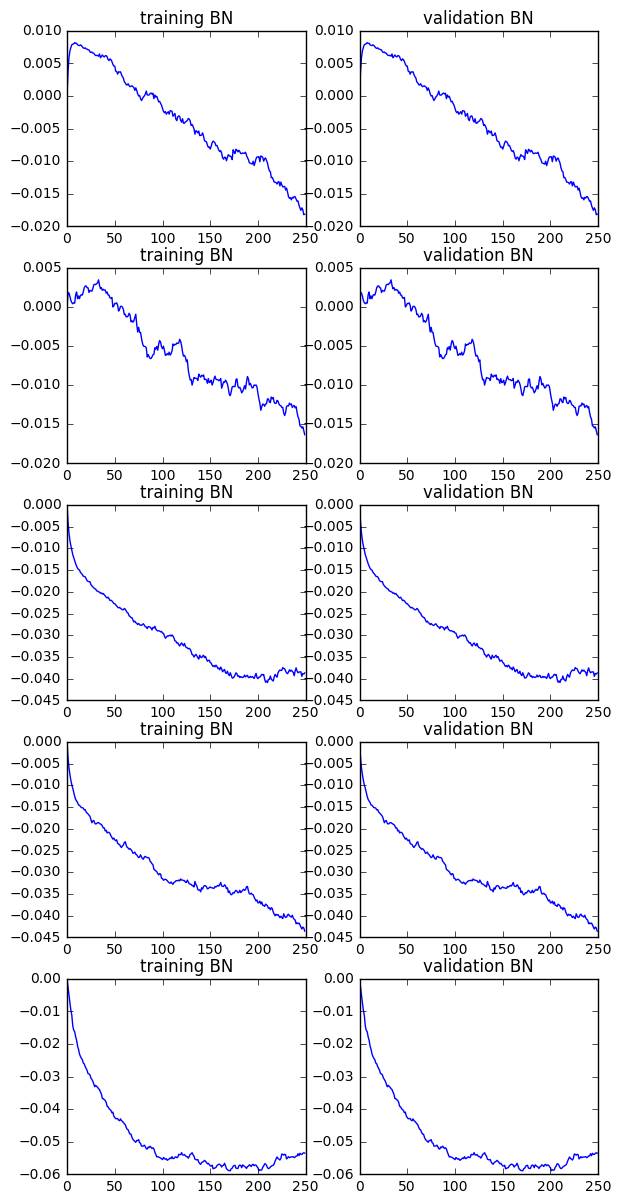

In [23]:
fig, axes = plt.subplots(5, 2, figsize=(6,12))
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("training BN")
    ax[1].set_title("validation BN")
    ax[0].plot(BNs_train[:,i])
    ax[1].plot(BNs_test[:,i])

In [25]:

sess.close()
tf.reset_default_graph()
( (x_image, y_dsize, y_d1, y_d2, y_d3, y_d4, y_d5, keep_prob), 
 train_step, accuracy, z_conv2, saver) = build_graph(is_training=True)

predictions = []
correct = 0

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    saver.restore(sess, saved_model)
    for i in range(1000):
    
        (batch_x, batch_y_dsize, batch_y_d1, 
         batch_y_d2, batch_y_d3, batch_y_d4, batch_y_d5) = next_batch(val_X, val_digit_size, val_digits, 
                                                                      10, replace = False)
        feed_dict={x_image: batch_x, 
                   y_dsize: batch_y_dsize,y_d1: batch_y_d1, 
                   y_d2: batch_y_d2, y_d3: batch_y_d3,y_d4: batch_y_d4, 
                   y_d5: batch_y_d5, keep_prob: 1}
    
        corr = sess.run(accuracy,
                         feed_dict=feed_dict)
        correct += corr
    #predictions.append(pred[0])
#print("PREDICTIONS:", predictions)
print("ACCURACY:", correct/1000)

('ACCURACY:', 0.89999999511241913)


In [61]:
a = [1,2,3,4]
a[-1]

4

In [63]:
a[1:]

[2, 3, 4]

In [72]:
[1]

[1]